In [2]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_sticking_solver_1_numba.json")
data = load_data("../stats/fpm_2_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

# data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_0_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_0_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_1_open_solver_1_numba.json")

# data = load_data("../stats/fpm_01_open_solver_1_numba.json")
# data = load_data("../stats/fpm_01_sticking_solver_1_numba.json")


# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

In [3]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
# from fpm_0 import make_model
# from fpm_01 import make_model
# from fpm_1 import make_model
from fpm_2 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

# reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


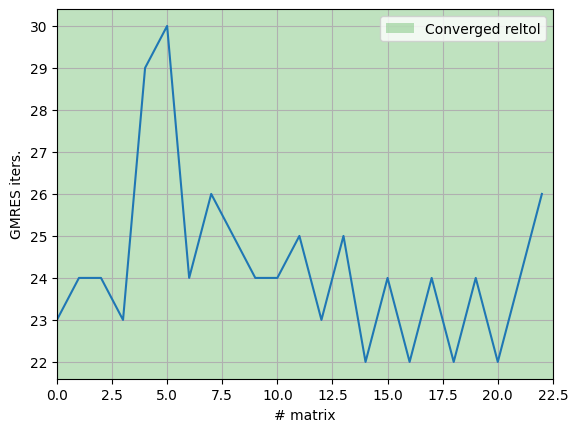

In [4]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [5]:
mat_idx = 7
get_gmres_iterations(data)[mat_idx]

26

In [6]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 2
sliding = 6
open = 160
transition = 328
total = 168


In [7]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

In [21]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()

Solve  took: 0.26
True residual decrease: 3.720653934901067e-13


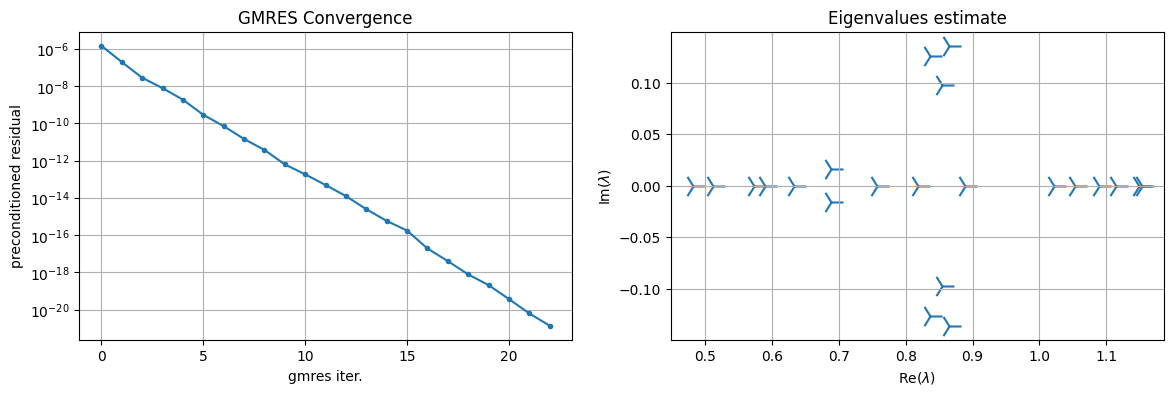

In [20]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs), tol=1e-15)

In [22]:
_ = model._prepare_solver()

In [11]:
# %reload_ext line_profiler
# from block_matrix import make_solver
# from mat_utils import inv_block_diag
# from fixed_stress import make_fs, make_local_stab_15, make_local_inverse_15, assemble_localization_matrices_mechanics

# %lprun -f model._prepare_solver -f make_solver -f inv_block_diag -f make_fs -f make_local_stab_15 -f make_local_inverse_15 -f assemble_localization_matrices_mechanics (perm_mat, prec_orig) = model._prepare_solver()

Timer unit: 1e-09 s

Total time: 0.460368 s
File: /home/porepy/simulations/block_matrix.py
Function: make_solver at line 490

Line #      Hits         Time  Per Hit   % Time  Line Contents
   490                                           def make_solver(schema: SolveSchema, mat_orig: BlockMatrixStorage):
   491         4       4024.0   1006.0      0.0      groups_0 = schema.groups
   492         4      29285.0   7321.2      0.0      groups_1 = get_complement_groups(schema)
   493                                           
   494         4      18543.0   4635.8      0.0      assert len(set(groups_0).intersection(groups_1)) == 0
   495                                           
   496         4    7122083.0    2e+06      1.5      submat_00 = mat_orig[groups_0, groups_0]
   497                                           
   498         4       5786.0   1446.5      0.0      if schema.color_spy:
   499                                                   submat_00.color_spy()
   500            

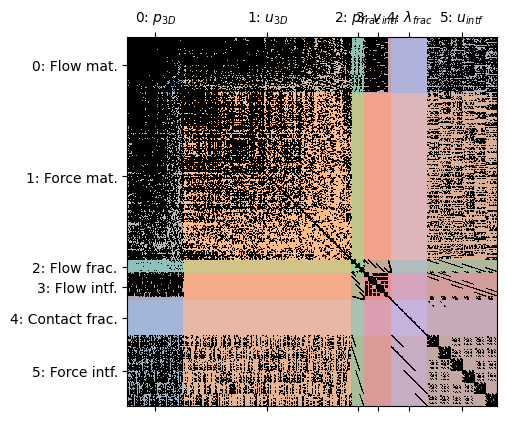

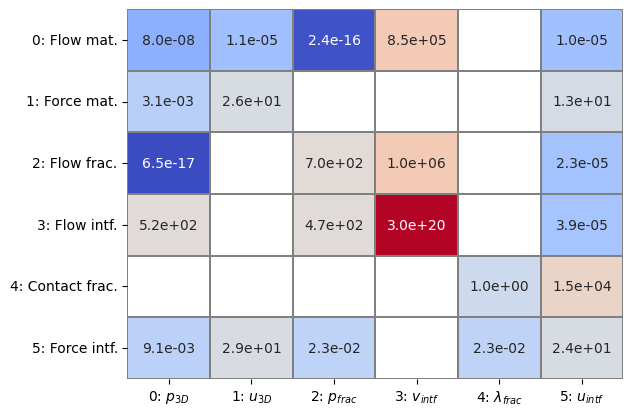

In [16]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

J = model.bmat
J.groups_row_names = [
    r"Flow mat.",
    r"Force mat.",
    r"Flow frac.",
    r"Flow intf.",
    r"Contact frac.",
    "Force intf.",
]
J.groups_col_names = [
    r"$p_{3D}$",
    r"$u_{3D}$",
    r"$p_{frac}$",
    r"$v_{intf}$",
    r"$\lambda_{frac}$",
    "$u_{intf}$",
]

J[:].color_spy()
J[:].plot_max()

# Good one

/home/porepy/simulations/mat_utils.py:318: UserWarning: Matrix contained nondiagonal elements. Inversion is inefficient.
  warn("Matrix contained nondiagonal elements. Inversion is inefficient.")


Solve  took: 0.27
True residual decrease: 2.655938418592626e-13


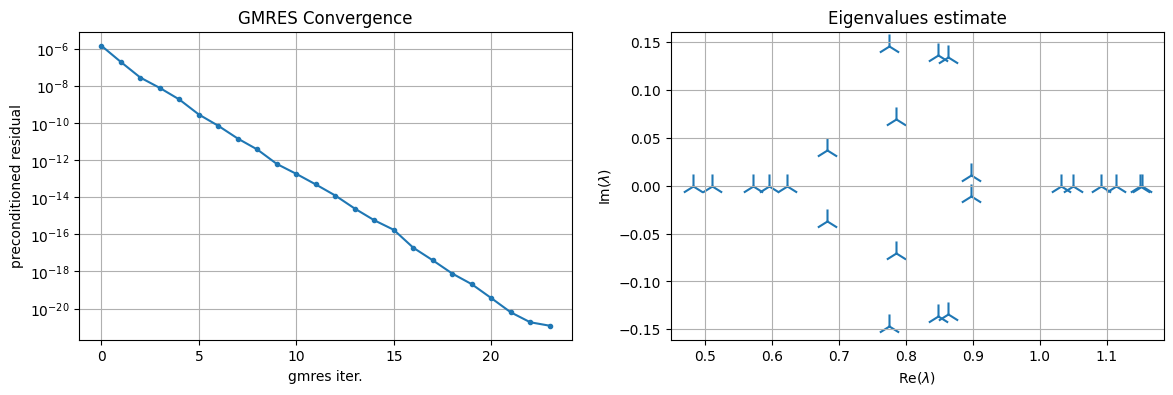

In [17]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_local_inverse_15, make_fs

schema = SolveSchema(
    groups=[3],
    solve=lambda bmat: PetscILU(bmat[[3]].mat),
    invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
    complement=SolveSchema(
        groups=[4],
        solve=lambda bmat: make_J44_inv_bdiag(model, bmat=bmat),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            invertor=lambda bmat: make_fs(model, bmat).mat,
            invertor_type="physical",
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        ),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), tol=1e-15, pc_side='left')

# Naive approach

Solve  took: 0.35
True residual decrease: 4.570718744685091e-06


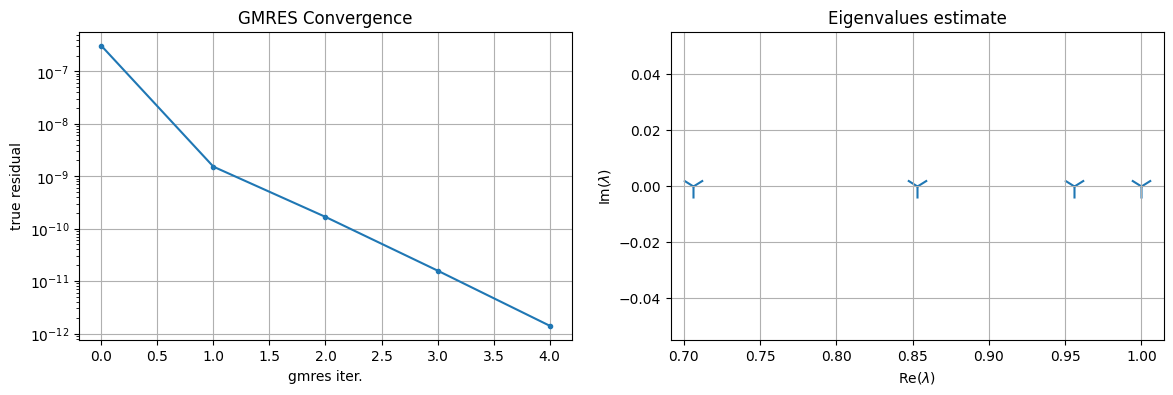

In [14]:
schema = SolveSchema(
    groups=[2, 3, 4, 5],
    complement=SolveSchema(
        groups=[1],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1]].mat, dim=model.nd),
        invertor=lambda bmat: get_fixed_stress_stabilization(model),
        invertor_type="physical",
        complement=SolveSchema(
            groups=[0],
            solve=lambda bmat: PetscAMGFlow(mat=bmat[[0]].mat),
        ),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), pc_side='right', tol=1e-5)